In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# Cargar los datos

In [2]:
## carga
PARQUET_PATH = "../data/raw/nvda.parquet"

## Cargar los datos
df = pd.read_parquet(PARQUET_PATH)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2010-10-18 00:00:00+00:00 to 2025-10-16 00:00:00+00:00
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Close                      3773 non-null   float64
 1   High                       3773 non-null   float64
 2   Low                        3773 non-null   float64
 3   Open                       3773 non-null   float64
 4   Volume                     3773 non-null   int64  
 5   treasury_yield_10y         3773 non-null   float64
 6   fed_funds_rate             3773 non-null   float64
 7   inflation_expectation_10y  3773 non-null   float64
 8   dollar_index               3773 non-null   float64
 9   oil_price_wti              3773 non-null   float64
 10  vix_volatility             3773 non-null   float64
 11  yield_spread_10y_2y        3773 non-null   float64
 12  high_yield_spread          3773 non-null   float64
dtype

In [3]:
## graficar la columna 'Close' a lo largo del tiempo
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["Close"],
        mode="lines",
        name="Close Price",
        line=dict(width=2),
    )
)

fig.update_layout(
    title="NVDA Close Price Over Time",
    xaxis_title="Date",
    yaxis_title="Close Price (USD)",
    hovermode="x unified",
    template="plotly_white",
    width=900,
    height=500,
)

fig.show()



In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- columnas base del precio ---
price_cols = ["Close", "High", "Low", "Open"]

# --- otras columnas (exógenas, volumen, etc.) ---
other_cols = [c for c in df.select_dtypes(include="number").columns if c not in price_cols]

# --- crear figura con subplots (1 para precios + 1 por cada columna extra) ---
fig = make_subplots(
    rows=1 + len(other_cols),
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    subplot_titles=["Precio de NVDA (Close, High, Low, Open)"] + other_cols
)

# --- Subplot 1: todas las columnas de precio en un solo gráfico ---
for col in price_cols:
    if col in df.columns:
        fig.add_trace(
            go.Scatter(x=df.index, y=df[col], mode="lines", name=col),
            row=1, col=1
        )

# --- Subplots individuales para las demás columnas ---
for i, col in enumerate(other_cols, start=2):
    fig.add_trace(
        go.Scatter(x=df.index, y=df[col], mode="lines", name=col),
        row=i, col=1
    )

# --- Ajustes de diseño ---
fig.update_layout(
    height=300 * (1 + len(other_cols)),
    title_text="Series temporales: precios combinados y variables exógenas",
    template="plotly_white",
    hovermode="x unified",
)

fig.update_xaxes(title_text="Fecha", row=len(other_cols)+1, col=1)
fig.update_yaxes(title_text="USD", row=1, col=1)

fig.show()


Valores nulos totales por columna:

Close                        0
High                         0
Low                          0
Open                         0
Volume                       0
treasury_yield_10y           0
fed_funds_rate               0
inflation_expectation_10y    0
dollar_index                 0
oil_price_wti                0
vix_volatility               0
yield_spread_10y_2y          0
high_yield_spread            0
dtype: int64


<Figure size 1000x600 with 0 Axes>

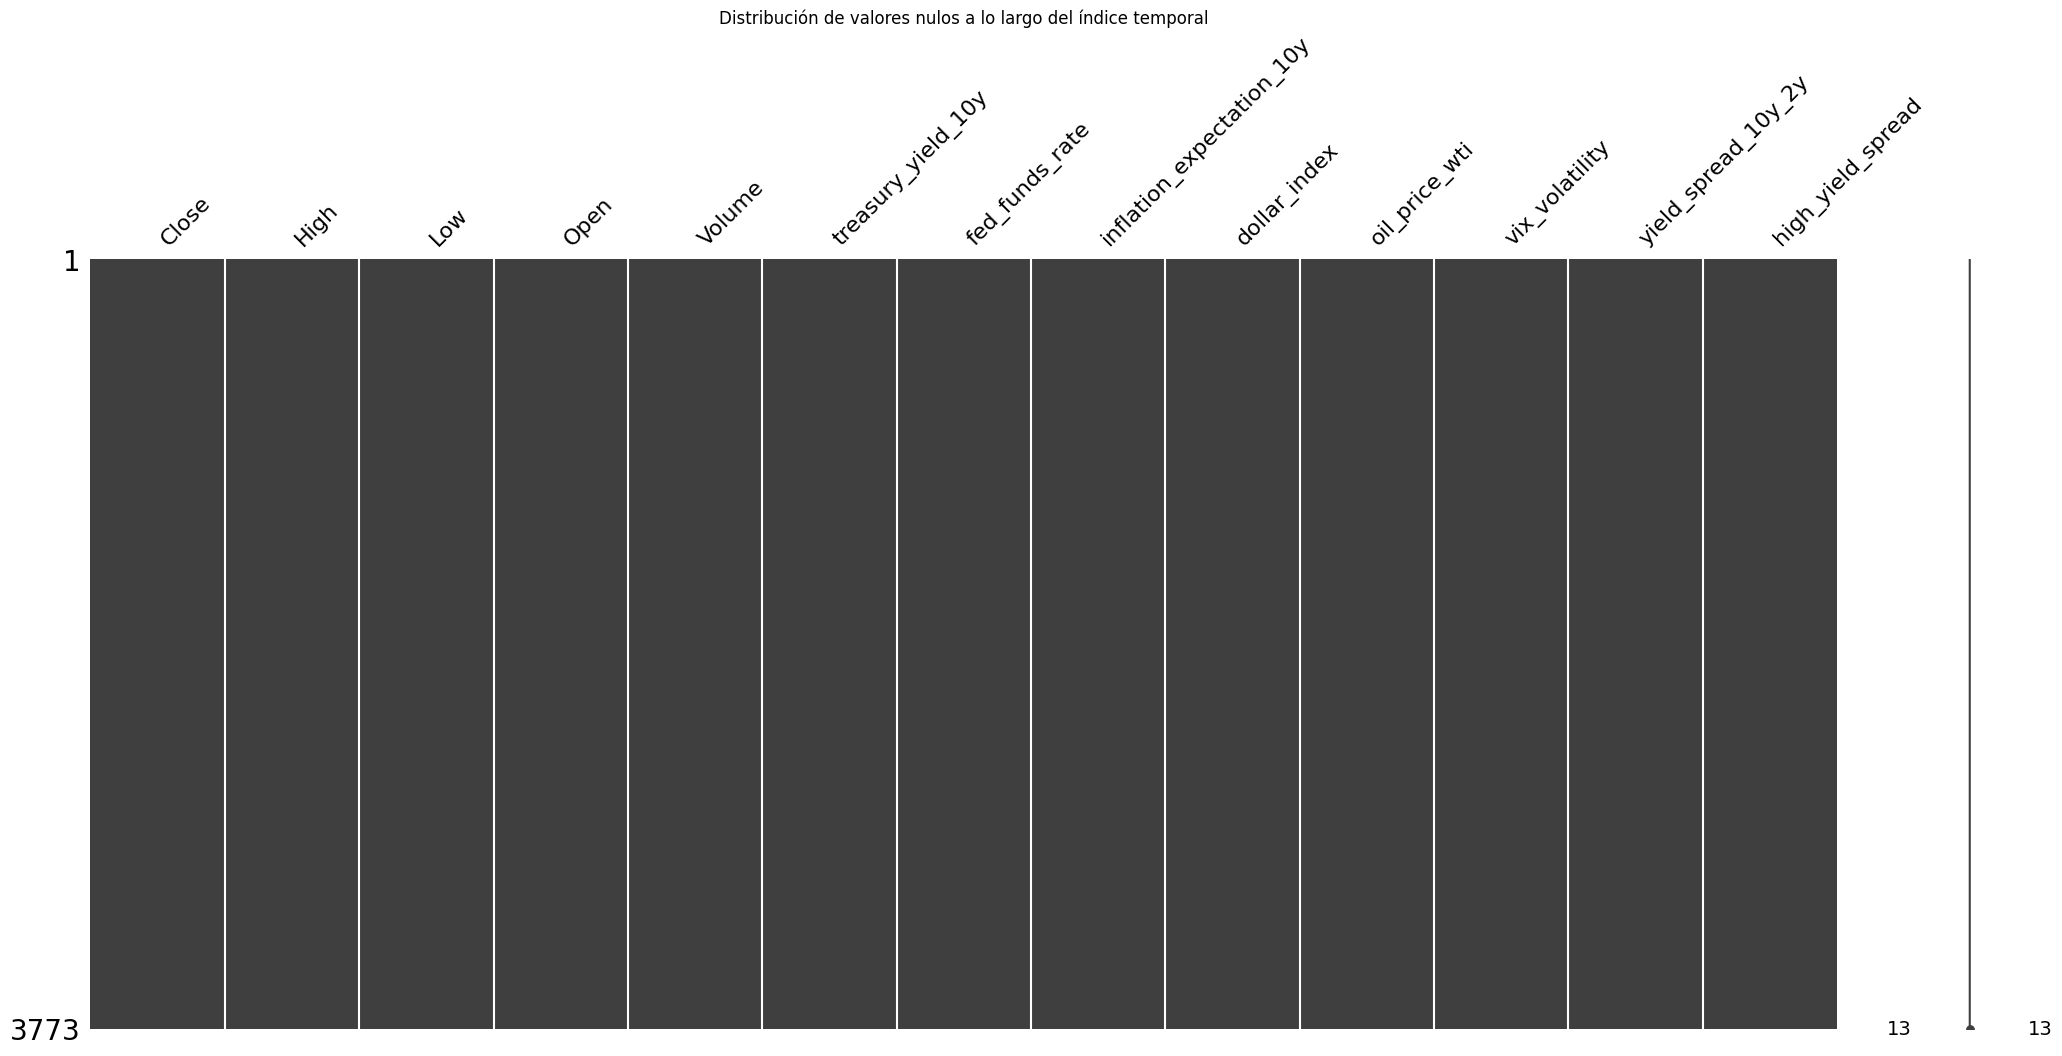

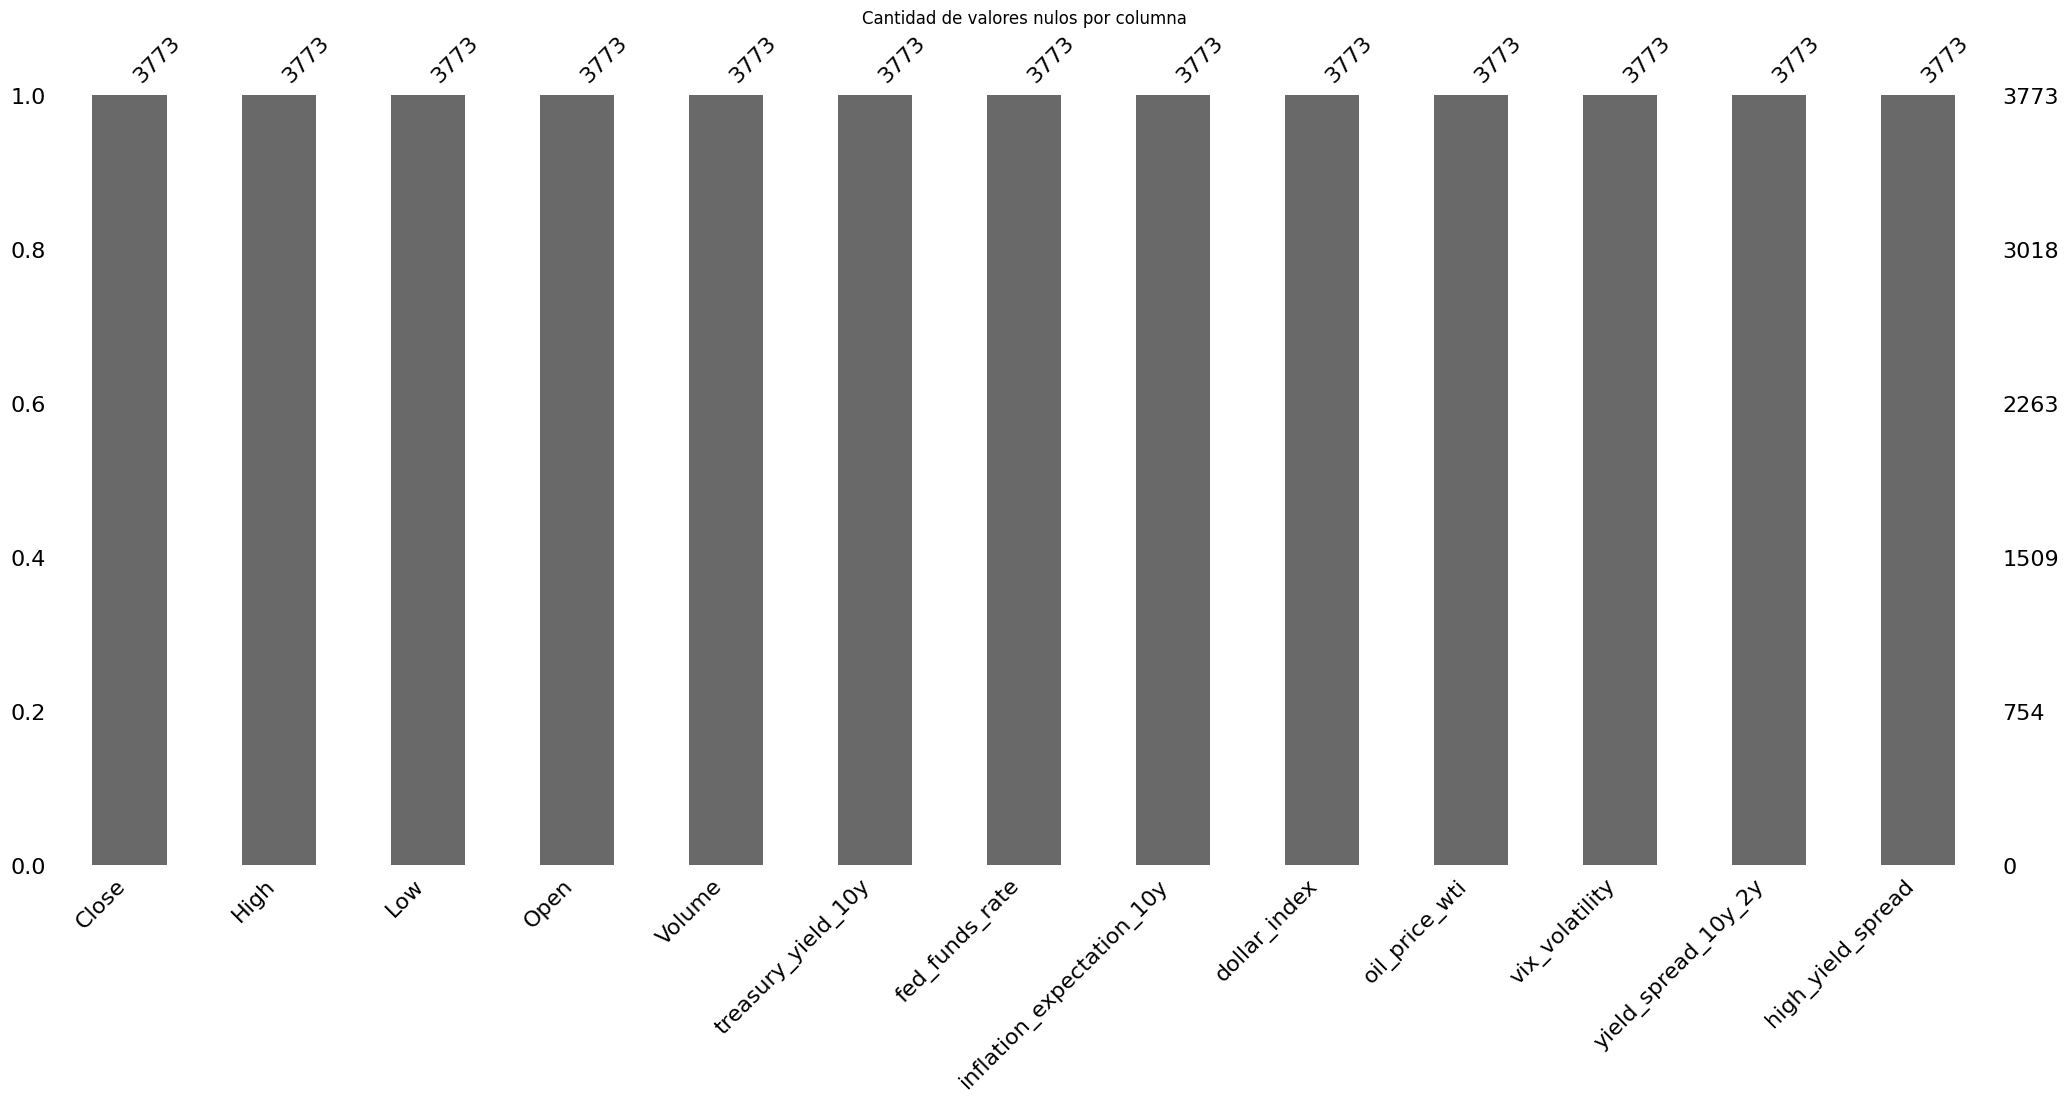

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

# --- 1. Resumen general ---
print("Valores nulos totales por columna:\n")
print(df.isnull().sum().sort_values(ascending=False))

# --- Matriz de nulos (visualiza el patrón de ausencias en el tiempo) ---
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title("Distribución de valores nulos a lo largo del índice temporal")
plt.show()

# --- Diagrama de barras (cantidad de nulos por columna) ---
plt.figure(figsize=(10, 6))
msno.bar(df)
plt.title("Cantidad de valores nulos por columna")
plt.show()


In [6]:
# Asegura índice datetime, único y ordenado
df = df.copy()
df.index = pd.to_datetime(df.index)
df = df[~df.index.duplicated()].sort_index()

print("Rango:", df.index.min(), "→", df.index.max())
print("Filas:", len(df), "| Fechas únicas:", df.index.nunique())
print("Monotónico:", df.index.is_monotonic_increasing)
print("Frecuencia inferida:", pd.infer_freq(df.index))


Rango: 2010-10-18 00:00:00+00:00 → 2025-10-16 00:00:00+00:00
Filas: 3773 | Fechas únicas: 3773
Monotónico: True
Frecuencia inferida: None


In [7]:
all_days = pd.date_range(df.index.min(), df.index.max(), freq="D")
missing_calendar_days = all_days.difference(df.index)

print("Días de calendario faltantes:", len(missing_calendar_days))
print(missing_calendar_days[:10])  # muestra algunos


Días de calendario faltantes: 1705
DatetimeIndex(['2010-10-23 00:00:00+00:00', '2010-10-24 00:00:00+00:00',
               '2010-10-30 00:00:00+00:00', '2010-10-31 00:00:00+00:00',
               '2010-11-06 00:00:00+00:00', '2010-11-07 00:00:00+00:00',
               '2010-11-13 00:00:00+00:00', '2010-11-14 00:00:00+00:00',
               '2010-11-20 00:00:00+00:00', '2010-11-21 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


# correlaciones

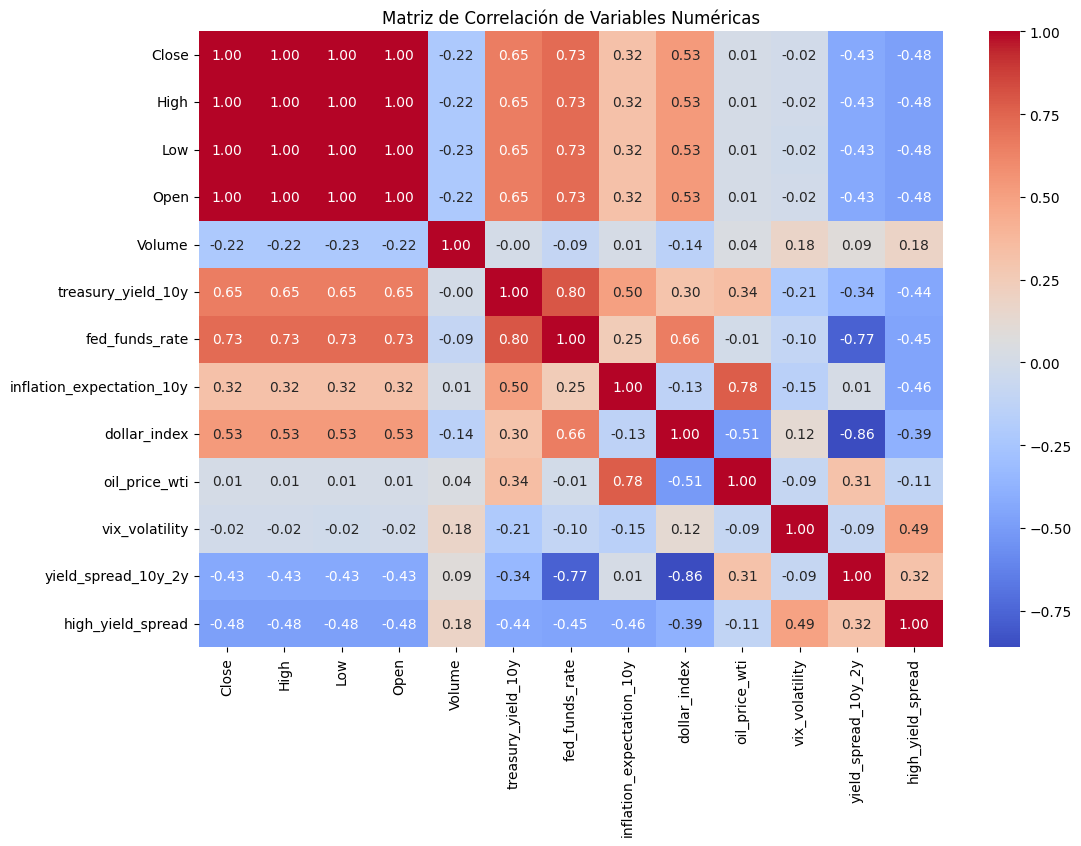

In [8]:
# correlation matriximport seaborn as sns
import seaborn as sns   
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()